<a href="https://colab.research.google.com/github/Saket2310/Anime-Classification-using-CNN/blob/main/Anime_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dataPath = '/content/drive/MyDrive/ANIME (3)'

In [ ]:
# Import Libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import numpy as np
import cv2
import glob
import random

from IPython.display import Image
import matplotlib.pyplot as plt

In [ ]:
TargetSize = (224,224)
def prepare_image(filepath):
    img = cv2.imread(filepath)
    img_resized = cv2.resize(img, TargetSize, interpolation=cv2.INTER_CUBIC)
    img_result  = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    return img_result

# **Prepare Data**

In [ ]:
dirList = glob.glob(dataPath+'/*') # list of all directories in dataPath
dirList.sort() # sorted in alphabetical order
print(dirList)

['/content/drive/MyDrive/ANIME (3)/kirito', '/content/drive/MyDrive/ANIME (3)/naruto', '/content/drive/MyDrive/ANIME (3)/tanjirou']


In [ ]:
Y_data = []
for i in range(len(dirList)):
    fileList = glob.glob(dirList[i]+'/*')
    [Y_data.append(i) for file in fileList]
print(Y_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
X_data = []
for i in range(len(dirList)):
    fileList = glob.glob(dirList[i]+'/*')
    [X_data.append(prepare_image(file)) for file in fileList]
X_data = np.asarray(X_data)
print(X_data.shape)

(30, 224, 224, 3)


# **Shuffle** **data**

In [ ]:
## random shuffle
from sklearn.utils import shuffle
X_data, Y_data = shuffle(X_data, Y_data, random_state=0)


In [ ]:
print(Y_data)

[0, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0, 1, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 1]


12


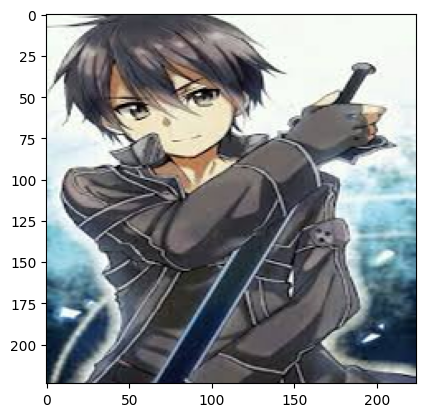

In [ ]:
testNum = random.randint(0,len(X_data))
print(testNum)
plt.imshow(X_data[testNum])

In [ ]:
num_classes = len(dirList)
labels = [dir.replace(dataPath+"/", "") for dir in dirList]
print(labels)

['kirito', 'naruto', 'tanjirou']


In [ ]:
equilibre = []
[equilibre.append(Y_data.count(i)) for i in range(len(dirList))]
print(equilibre)

[10, 10, 10]


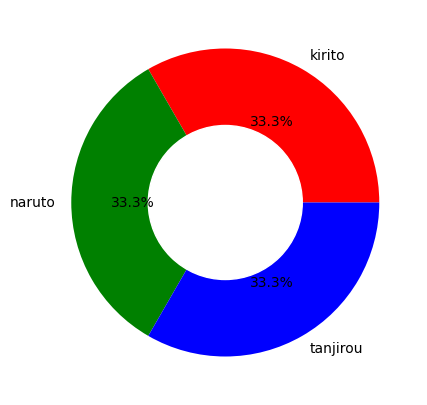

In [ ]:
# plot the circle of value counts in dataset
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(equilibre, labels=labels, colors=['red','green','blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# **Data Normalisation**

In [ ]:
# Data Normalisation
X_train = X_data / 255.0
print(X_train.shape)

(30, 224, 224, 3)


In [ ]:
# One-hot encoding
Y_train = to_categorical(Y_data)
print(Y_train.shape)

(30, 3)


# **Load MobileNet v2 model & add FC-layers**

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
# use MobieNet V2 as base model
base_model=MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)

# add Fully-Connected Layers to Model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) # FC layer 1
x=Dense(64,activation='relu')(x)   # FC layer 2
preds=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,635,523 (13.87 MB)

 Trainable params: 3,601,411 (13.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Check layers no. & name
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_layer_3
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_rel

# Set FC-layers to trainable

In [ ]:
# set extra layers to trainable
for layer in model.layers[:155]:
    layer.trainable=False
for layer in model.layers[155:]:
    layer.trainable=True

In [ ]:
 #Compile Model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train Model (target is loss <0.01)
batch_size= 16
num_epochs = 10
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=num_epochs)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 603ms/step - accuracy: 0.4347 - loss: 1.2011
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 0.6972 - loss: 0.7619
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - accuracy: 0.8681 - loss: 0.2500
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - accuracy: 0.9569 - loss: 0.1843
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 1.0000 - loss: 0.0421
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 1.0000 - loss: 0.0413
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step - accuracy: 1.0000 - loss: 0.0158
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 907ms/step - accuracy: 1.0000 - loss: 0.0123
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 1.0000 - loss: 0.0044
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0018


# **Save Model**

In [ ]:
# Save Model
model.save('tl_animes.h5')

# **Test Model**

**check 1 picture per category**

In [ ]:
def classify_worms(imageFile):
    testData = prepare_image(imageFile).reshape(1,224,224,3)
    testData = testData / 255.0
    predictions = model.predict(testData)
#    print(predictions[0])
    maxindex = int(np.argmax(predictions))
    print(predictions[0][maxindex],labels[maxindex])
    return labels[maxindex]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0.9999459 kirito


'kirito'

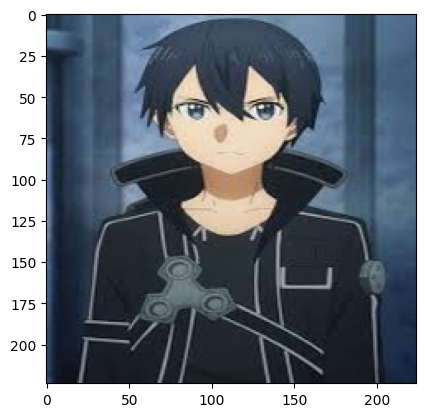

In [ ]:
imageFile=dirList[0]+'/01.jpg'
plt.imshow(prepare_image(imageFile))
classify_worms(imageFile)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
0.9995173 naruto


'naruto'

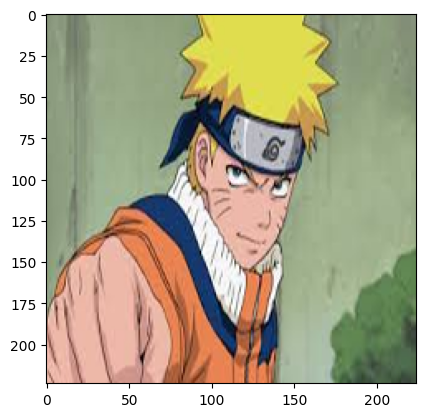

In [ ]:
imageFile=dirList[1]+'/01.jpg'
plt.imshow(prepare_image(imageFile))
classify_worms(imageFile)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
0.99995506 tanjirou


'tanjirou'

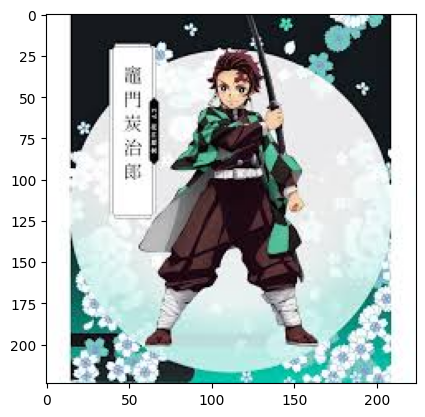

In [ ]:
imageFile=dirList[2]+'/01.jpg'
plt.imshow(prepare_image(imageFile))
classify_worms(imageFile)

# **check entire dataset**

In [ ]:
Y_pred = model.predict(X_train)
y_pred = np.argmax(Y_pred,axis=1)
#y_label= [labels[k] for k in y_pred]
cm = confusion_matrix(Y_data, y_pred)
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


Plot Confusion **Matrix**

In [ ]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

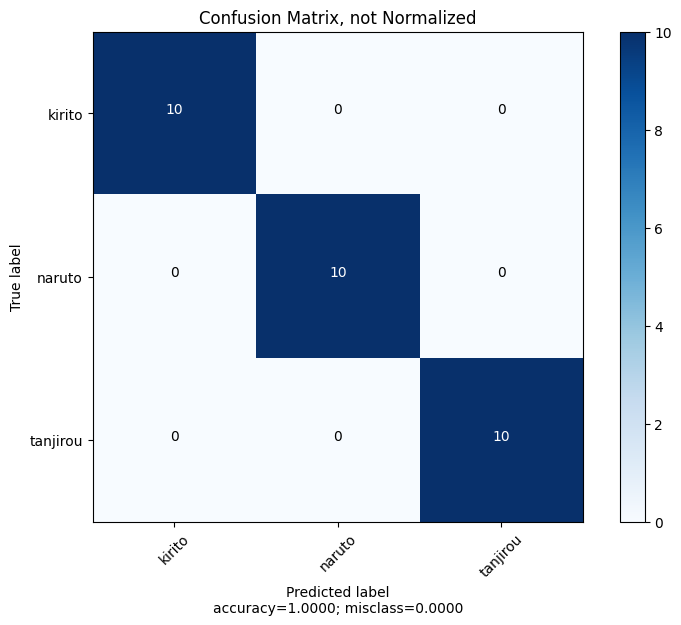

In [ ]:
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names = labels,
                      title="Confusion Matrix, not Normalized")

In [ ]:
print(classification_report(Y_data, y_pred, target_names=labels))

              precision    recall  f1-score   support

      kirito       1.00      1.00      1.00        10
      naruto       1.00      1.00      1.00        10
    tanjirou       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



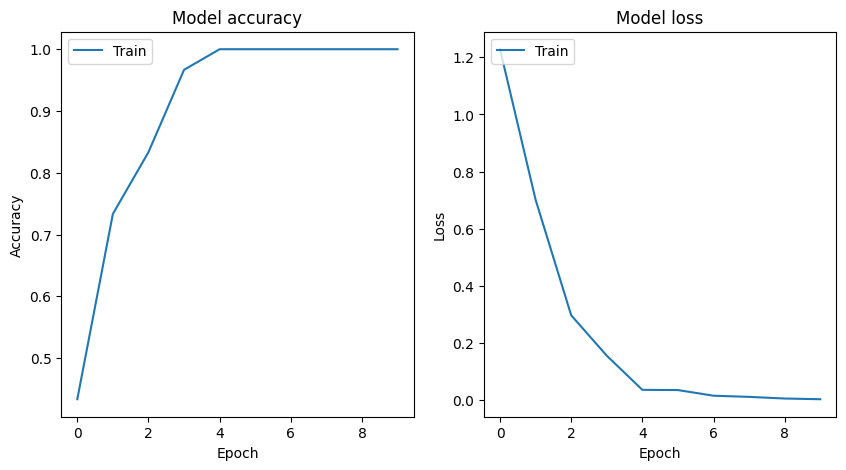

In [ ]:
# prompt: give a code for model accuracy for train and test  and plot its graph in one fig

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Assuming you have validation accuracy in your history
# If not, replace 'val_accuracy' with the correct key from history.history
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Assuming you have validation loss in your history
# If not, replace 'val_loss' with the correct key from history.history
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    plt.legend(['Train'], loc='upper left')

plt.show()

In [ ]:
# prompt: now build a new model as model 2

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import glob
import random
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import itertools

# ... (rest of your code from the previous response)

# Assuming you have already trained and saved the model as 'tl_animes.h5'

# Load the saved model (model 2)
model2 = keras.models.load_model('tl_animes.h5')


# Now you can use model2 for predictions
# Example:
# imageFile = 'path/to/your/image.jpg'
# prediction = classify_worms(imageFile, model=model2)  # Assuming classify_worms function takes an optional model parameter

# To make predictions with model2, modify the classify_worms function to accept the model as a parameter
def classify_worms(imageFile, model=None):
    testData = prepare_image(imageFile).reshape(1,224,224,3)
    testData = testData / 255.0
    if model:
      predictions = model.predict(testData)
    else:
      predictions = model2.predict(testData) #default to model2
    maxindex = int(np.argmax(predictions))
    print(predictions[0][maxindex],labels[maxindex])
    return labels[maxindex]

Confusion matrix, without normalization
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


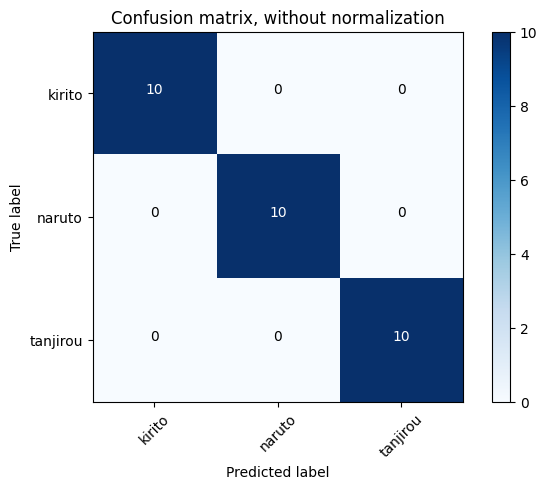

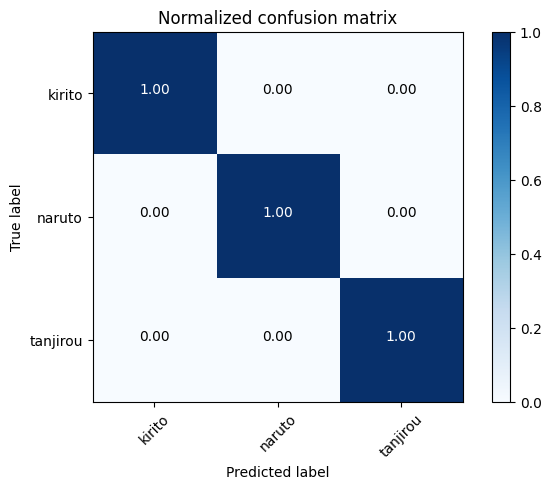

In [ ]:
# prompt: create a confusion matrix for this model

# Assuming you have already executed the code and have the necessary variables (Y_data, y_pred, labels)

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# ... (Your existing code)

# Calculate the confusion matrix
cm = confusion_matrix(Y_data, y_pred)

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot the normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

KeyError: 'val_accuracy'

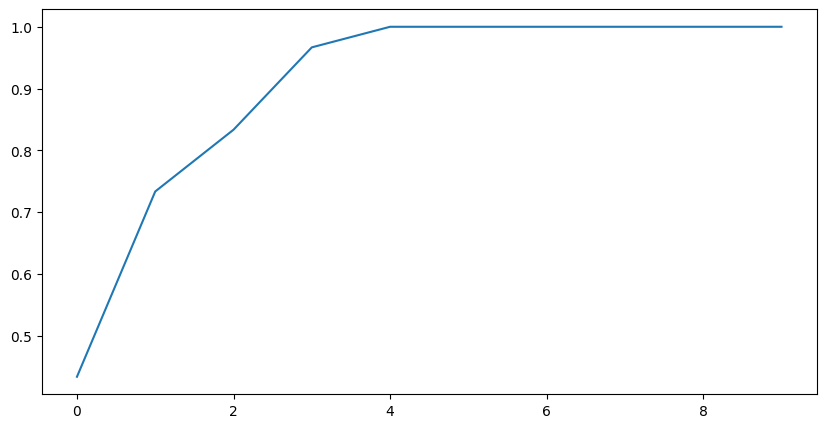

In [ ]:
# prompt: now generate a code for plot a graph of model accuracy test and train in one fig

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

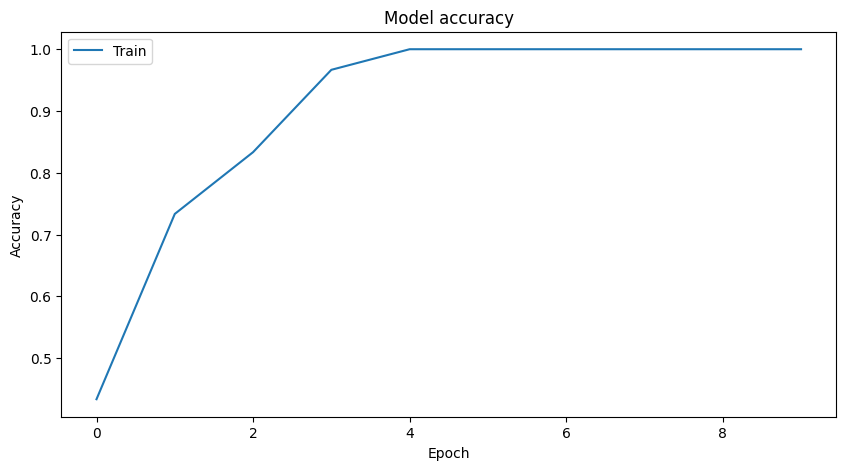

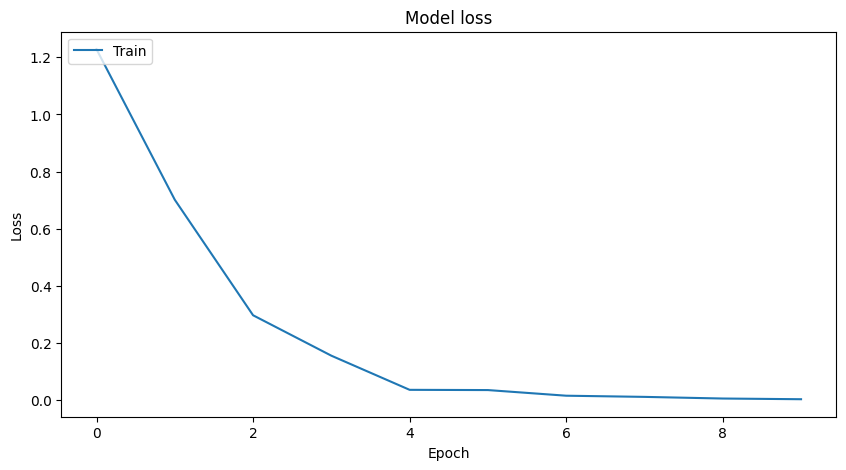

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
# Check if 'val_accuracy' exists in history.history
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    plt.legend(['Train'], loc='upper left')  # Only 'Train' legend if no validation data
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
# Check if 'val_loss' exists in history.history
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    plt.legend(['Train'], loc='upper left')  # Only 'Train' legend if no validation data
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

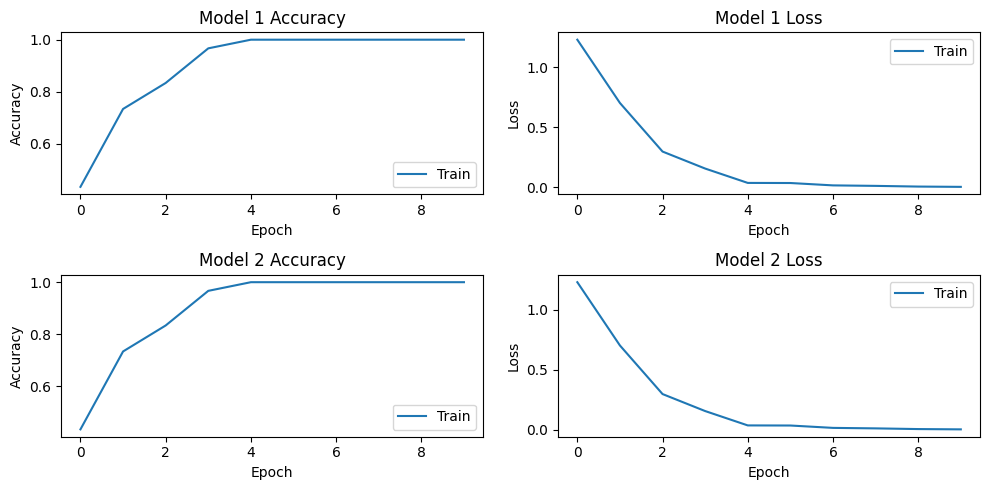

Model 1 Final Accuracy: 1.0
Model 1 Final Loss: 0.0019482634961605072
Model 2 Final Accuracy: 1.0
Model 2 Final Loss: 0.0019482634961605072


In [ ]:
# prompt: generate a code for Comparison of Model Validation Accuracy

# Assuming you have already trained two models (model and model2) and have their history objects (history and history2)

# Compare the accuracy and loss plots
plt.figure(figsize=(10, 5))

# Model 1
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train', 'Validation'], loc='lower right')
else:
  plt.legend(['Train'], loc='lower right')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Validation'], loc='upper right')
else:
  plt.legend(['Train'], loc='upper right')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')


# Model 2 (replace history with history2 if available)
# Assuming history2 is for model2
plt.subplot(2, 2, 3)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train', 'Validation'], loc='lower right')
else:
  plt.legend(['Train'], loc='lower right')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 4)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Validation'], loc='upper right')
else:
  plt.legend(['Train'], loc='upper right')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Print final accuracy and loss values for both models
print(f"Model 1 Final Accuracy: {history.history['accuracy'][-1]}")
print(f"Model 1 Final Loss: {history.history['loss'][-1]}")

print(f"Model 2 Final Accuracy: {history.history['accuracy'][-1]}") # Replace with history2
print(f"Model 2 Final Loss: {history.history['loss'][-1]}") # Replace with history2